# `Part 3/3: Order Book depth data collection with Binance API`

The purpose of this series of notebooks is to showcase real-time candle, trade and order book data collection methods from Binance exchange.

Data is collected through websockets and then stored in SQL databases.

Possible applications of the stored data include:
* creation of custom alerts for discretionary trading 
* development of a fully automated systematic training system based on a set of predetermined rules

#### Author: Vladislav Semin

## 1. Import libraries

In [1]:
import time
import calendar
from datetime import datetime

import pandas as pd #to create a dataframe

import websocket
from binance.client import Client # Import the Binance Client
from binance.websockets import BinanceSocketManager # Import the Binance Socket Manager

import sqlalchemy as db
from sqlalchemy import create_engine

import itertools # Necessary for the OB data structure we will create

## 2. Setup Binance websocket connection

**IMPORTANT NOTE:** 
This kernel will not run without API keys. Register an account at Binance crypto exchange website to get your API keys:
* https://www.binance.com/en/register

In [2]:
# Input Binance API keys
# PUBLIC = ''
# SECRET = ''

In [3]:
# Setup Binance websocket connection
client = Client(api_key=PUBLIC, api_secret=SECRET)
bm = BinanceSocketManager(client)

## 3. Select cryptocurrency pair

In [4]:
# We will be collecting data for the following cryptocurrency pair
pair = 'ETHBTC'

## 4. Setup SQL database

In [5]:
# Name of SQL database
depth_db = 'binance_depth_{}'.format(pair)

In [6]:
# Set up engine to append the values to the SQL database
engine = create_engine('sqlite:///{}.db'.format(depth_db), echo=False) 

## 5. Set up data collection format

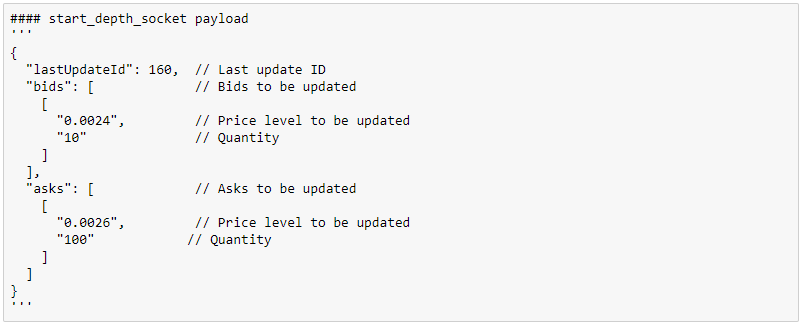

## Create a custom data structure to extract & store OB data

In [7]:
# process_message_depth is a callback function requested by .start_depth_socket method of BinanceSocketManager class
def process_message_depth(msg):
   
    global engine
    global pair
    global depth_db
    
    # Timestamp at the time of depth collection converted to date time with microseconds
    timestamp = datetime.now()
    time_ = timestamp.strftime("%Y-%m-%d %H:%M:%S.%f")

    
    # Creating a data structure to store OB data
    # First we deal with the bids side of P & Q
    bids = msg['bids']
    
    # Extract price and quantity values
    bid_vals = list(itertools.chain.from_iterable(bids))
    
    # Reverse the order of values so that Bid prices are in ascending order 
    # from farthest to closest to mkt value
    bid_vals.reverse()
    
    # Create a list of price-quantity tuples(our preliminary keys)
    b_k_t = [('Bid(-{}) P'.format(str(x)), ('Bid(-{}) Q'.format(str(x)))) for x in range(21) if x > 0]
    
    # Create a list of keys
    bid_keys = list(itertools.chain.from_iterable(b_k_t))
    
    # Reverse the order of values so that key descriptions are in ascending order 
    # from farthest to closest to mkt value
    bid_keys.reverse()
    
    # Zip key and value lists to produce a 20 closest bids dictionary!
    bids_dict = dict(zip(bid_keys, bid_vals))
    
    
    # Secondly, we deal with the asks side of P & Q
    asks = msg['asks']
    
    ask_vals = list(itertools.chain.from_iterable(asks))
    
    # with Asks we do not need to reverse the order of keys and values
    a_k_t = [('Ask(+{}) P'.format(str(x)), ('Ask(+{}) Q'.format(str(x)))) for x in range(21) if x > 0]
    
    ask_keys = list(itertools.chain.from_iterable(a_k_t))
    
    # Zip key and value lists to produce a 20 closest asks dictionary!
    asks_dict = dict(zip(ask_keys, ask_vals))
    
    
    # Thirdly, we concatenate bids and asks dictionaries
    bids_dict.update(asks_dict)
    
    # In-fourth we collect supplementary important time data
    time_depth_dict = {"OB @ Time": time_, "Timestamp": timestamp, 
                 "lastUpdateId": msg['lastUpdateId'], "Pair": pair}
    
    # Finally, we concatenate bids&asks dict with time dict to get the final OB data!
    time_depth_dict.update(bids_dict)
               
        
    depth_stream_df = pd.DataFrame([time_depth_dict]).set_index('OB @ Time')  
    
    # real-time export of streaming dataframes to SQLite database        
    depth_stream_df.to_sql(depth_db, if_exists="append", con=engine)
    
    print('### {} OB depth data updated at {}'.format(pair, time_))

## 6. Collect OB depth data

In [8]:
# Connect to collect data
# Select depth equal to 20: this means we get 20 bid and 20 ask quotes
conn_key_depth = bm.start_depth_socket(pair, process_message_depth, 
                                 depth=BinanceSocketManager.WEBSOCKET_DEPTH_20)
# Start data collection
bm.start()

# For testing purposes, streaming period is set to 15 seconds. Max connection time is 24 hrs.
time.sleep(15) 

bm.stop_socket(conn_key_depth)

bm.close()

### ETHBTC OB depth data updated at 2020-04-23 01:43:26.065902
### ETHBTC OB depth data updated at 2020-04-23 01:43:27.072699
### ETHBTC OB depth data updated at 2020-04-23 01:43:28.074960
### ETHBTC OB depth data updated at 2020-04-23 01:43:29.077277
### ETHBTC OB depth data updated at 2020-04-23 01:43:30.079829
### ETHBTC OB depth data updated at 2020-04-23 01:43:31.080497
### ETHBTC OB depth data updated at 2020-04-23 01:43:32.081650
### ETHBTC OB depth data updated at 2020-04-23 01:43:33.081757
### ETHBTC OB depth data updated at 2020-04-23 01:43:34.082140
### ETHBTC OB depth data updated at 2020-04-23 01:43:35.082474
### ETHBTC OB depth data updated at 2020-04-23 01:43:36.083483
### ETHBTC OB depth data updated at 2020-04-23 01:43:37.089939
### ETHBTC OB depth data updated at 2020-04-23 01:43:38.088841


## 7. Check the data appended to SQL database

In [9]:
#select and show data from the dataframe
binance_depth = engine.execute("SELECT * FROM " + depth_db).fetchall()

print(binance_depth)

[('2020-04-23 01:43:26.065902', '2020-04-23 01:43:26.065902', 1165619462, 'ETHBTC', '8.01000000', '0.02559300', '0.00500000', '0.02559400', '1.90100000', '0.02559500', '236.70100000', '0.02559700', '115.54500000', '0.02559800', '15.61500000', '0.02559900', '23.42200000', '0.02560000', '7.85500000', '0.02560100', '11.65700000', '0.02560300', '7.80600000', '0.02560400', '64.50000000', '0.02560500', '2.74600000', '0.02560600', '116.24800000', '0.02560700', '7.22300000', '0.02560800', '31.51600000', '0.02560900', '0.39000000', '0.02561000', '8.23900000', '0.02561100', '6.08600000', '0.02561200', '143.00000000', '0.02561300', '1.59900000', '0.02561400', '0.02562300', '0.51400000', '0.02562400', '37.55700000', '0.02562500', '0.81300000', '0.02562700', '10.03600000', '0.02562800', '8.24200000', '0.02562900', '7.80500000', '0.02563100', '12.59900000', '0.02563200', '23.41900000', '0.02563300', '12.86900000', '0.02563400', '119.99800000', '0.02563500', '7.69400000', '0.02563600', '7.82000000', 

In [10]:
# Or we can transform SQL data into pandas dataframe
df = pd.DataFrame(binance_depth, columns=["OB @ Time", "Timestamp", "lastUpdateId", "Pair", 
                                          'Bid(-20) Q', 'Bid(-20) P', 'Bid(-19) Q', 'Bid(-19) P',
                                          'Bid(-18) Q', 'Bid(-18) P', 'Bid(-17) Q', 'Bid(-17) P',
                                          'Bid(-16) Q', 'Bid(-16) P', 'Bid(-15) Q', 'Bid(-15) P', 
                                          'Bid(-14) Q', 'Bid(-14) P', 'Bid(-13) Q', 'Bid(-13) P', 
                                          'Bid(-12) Q', 'Bid(-12) P', 'Bid(-11) Q', 'Bid(-11) P', 'Bid(-10) Q',
                                          'Bid(-10) P', 'Bid(-9) Q', 'Bid(-9) P', 'Bid(-8) Q', 
                                          'Bid(-8) P', 'Bid(-7) Q', 'Bid(-7) P', 'Bid(-6) Q',
                                          'Bid(-6) P', 'Bid(-5) Q', 'Bid(-5) P', 'Bid(-4) Q',
                                          'Bid(-4) P', 'Bid(-3) Q', 'Bid(-3) P', 'Bid(-2) Q', 
                                          'Bid(-2) P', 'Bid(-1) Q', 'Bid(-1) P', 'Ask(+1) P', 
                                          'Ask(+1) Q', 'Ask(+2) P', 'Ask(+2) Q', 'Ask(+3) P', 
                                          'Ask(+3) Q', 'Ask(+4) P', 'Ask(+4) Q', 'Ask(+5) P',
                                          'Ask(+5) Q', 'Ask(+6) P', 'Ask(+6) Q', 'Ask(+7) P',
                                          'Ask(+7) Q', 'Ask(+8) P', 'Ask(+8) Q', 'Ask(+9) P',
                                          'Ask(+9) Q', 'Ask(+10) P', 'Ask(+10) Q', 'Ask(+11) P',
                                          'Ask(+11) Q', 'Ask(+12) P', 'Ask(+12) Q', 'Ask(+13) P',
                                          'Ask(+13) Q', 'Ask(+14) P', 'Ask(+14) Q', 'Ask(+15) P',
                                          'Ask(+15) Q', 'Ask(+16) P', 'Ask(+16) Q', 'Ask(+17) P',
                                          'Ask(+17) Q', 'Ask(+18) P', 'Ask(+18) Q', 'Ask(+19) P',
                                          'Ask(+19) Q', 'Ask(+20) P', 'Ask(+20) Q']).set_index('OB @ Time')

df

,Timestamp,lastUpdateId,Pair,Bid(-20) Q,Bid(-20) P,Bid(-19) Q,Bid(-19) P,Bid(-18) Q,Bid(-18) P,Bid(-17) Q,...,Ask(+16) P,Ask(+16) Q,Ask(+17) P,Ask(+17) Q,Ask(+18) P,Ask(+18) Q,Ask(+19) P,Ask(+19) Q,Ask(+20) P,Ask(+20) Q
OB @ Time,,,,,,,,,,,,,,,,,,,,,
2020-04-23 01:43:26.065902,2020-04-23 01:43:26.065902,1165619462,ETHBTC,8.01000000,0.02559300,0.00500000,0.02559400,1.90100000,0.02559500,236.70100000,...,0.02564000,136.16300000,0.02564100,46.50800000,0.02564200,0.07000000,0.02564300,7.82200000,0.02564400,13.27300000
2020-04-23 01:43:27.072699,2020-04-23 01:43:27.072699,1165619486,ETHBTC,0.00500000,0.02559400,1.90100000,0.02559500,236.70100000,0.02559700,115.54500000,...,0.02563800,9.67700000,0.02563900,5.93700000,0.02564000,140.06700000,0.02564100,46.50800000,0.02564200,0.07000000
2020-04-23 01:43:28.074960,2020-04-23 01:43:28.074960,1165619510,ETHBTC,0.00500000,0.02559400,1.90100000,0.02559500,236.70100000,0.02559700,109.98000000,...,0.02563900,5.93700000,0.02564000,140.06700000,0.02564100,46.50800000,0.02564200,0.07000000,0.02564300,7.82200000
2020-04-23 01:43:29.077277,2020-04-23 01:43:29.077277,1165619541,ETHBTC,0.10500000,0.02559400,236.70100000,0.02559700,109.98000000,0.02559800,15.61500000,...,0.02564100,46.50800000,0.02564200,0.07000000,0.02564300,7.82200000,0.02564400,13.27300000,0.02564500,10.58200000
2020-04-23 01:43:30.079829,2020-04-23 01:43:30.079829,1165619557,ETHBTC,0.10500000,0.02559400,236.70100000,0.02559700,109.98000000,0.02559800,15.61500000,...,0.02564100,46.50800000,0.02564200,0.07000000,0.02564300,7.82200000,0.02564400,13.27300000,0.02564500,10.58200000
2020-04-23 01:43:31.080497,2020-04-23 01:43:31.080497,1165619571,ETHBTC,8.01000000,0.02559300,0.10500000,0.02559400,236.70100000,0.02559700,109.98000000,...,0.02564100,46.50800000,0.02564200,0.07000000,0.02564300,7.82200000,0.02564400,13.27300000,0.02564500,10.58200000
2020-04-23 01:43:32.081650,2020-04-23 01:43:32.081650,1165619592,ETHBTC,0.10500000,0.02559400,236.70100000,0.02559700,109.98000000,0.02559800,15.61500000,...,0.02564100,46.50800000,0.02564200,0.07000000,0.02564300,7.82200000,0.02564400,13.27300000,0.02564500,10.58200000
2020-04-23 01:43:33.081757,2020-04-23 01:43:33.081757,1165619611,ETHBTC,236.70100000,0.02559700,109.98000000,0.02559800,17.51600000,0.02559900,23.42200000,...,0.02564100,46.50800000,0.02564200,0.07000000,0.02564300,7.82200000,0.02564400,13.27300000,0.02564500,10.58200000
2020-04-23 01:43:34.082140,2020-04-23 01:43:34.082140,1165619630,ETHBTC,0.10500000,0.02559400,236.70100000,0.02559700,109.98000000,0.02559800,17.51600000,...,0.02564100,46.50800000,0.02564200,0.07000000,0.02564300,7.82200000,0.02564400,4.73800000,0.02564500,10.58200000


## References:
#### Binance API Python libraries used in this demonstration:

https://gist.github.com/alexbrillant/961502146a7fc5d03205f9b07b8535f5 - Binance Socket Manager class and its methods

https://github.com/binance-exchange/python-binance